# Gaussian Process Regression

Testing fully Bayesian GP using Pyro for estimating uncertainties in model hyper-parameters.

In [1]:
# Set up local project directory path
from pathlib import Path
from tqdm.notebook import tqdm
import sys

project_src = Path('../src').resolve().as_posix()
sys.path.insert(0, project_src)

# try:
#     import lib.config
# except Exception:
#     raise Exception("Issue with dynamic import")

# config = lib.config.read_config()
# pwd = Path(config["pwd"])
src = Path('../output')

In [2]:
# Import modules needed for the rest of the notebook
import numpy as np
import pandas as pd

from scipy import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pytorch + GP + Pyro
import torch, gpytorch, pyro

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_fonts = {
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_fonts)

In [4]:
# CUDA setup
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print(f"Using {device}")

Using cpu


In [5]:
p = Path('../output/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

In [6]:
y = df.slope.to_numpy()
x = np.arange(len(y))

x_full = torch.tensor(x, dtype=torch.double)
y_full = torch.tensor(y, dtype=torch.double)

x_tr = torch.tensor(x[:700], dtype=torch.double)
y_tr = torch.tensor(y[:700], dtype=torch.double)

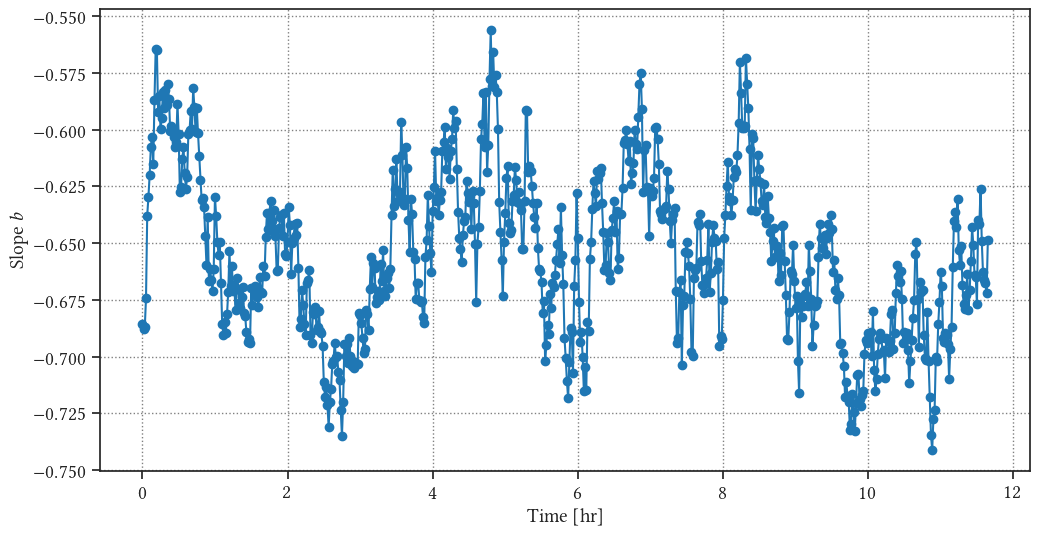

In [7]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(x_tr / 60, y_tr, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

In [8]:
xf = np.fft.rfft(y_tr.numpy())
yf = np.fft.rfftfreq(y_tr.shape[-1])

xx = 1 / yf
yy = np.abs(xf) ** 2 / len(xx)

_m = np.isfinite(xx) & np.isfinite(yy)

xx = xx[_m]
yy = yy[_m]

/tmp/ipykernel_543757/3770278785.py:4: RuntimeWarning: divide by zero encountered in divide
  xx = 1 / yf


In [9]:
# Find 95% confidence range
th = np.percentile(yy, 95) 
filtered = [x for x in yy if x <= th]

var = np.mean(filtered) * len(yf)

print(var)

0.18145321561966812


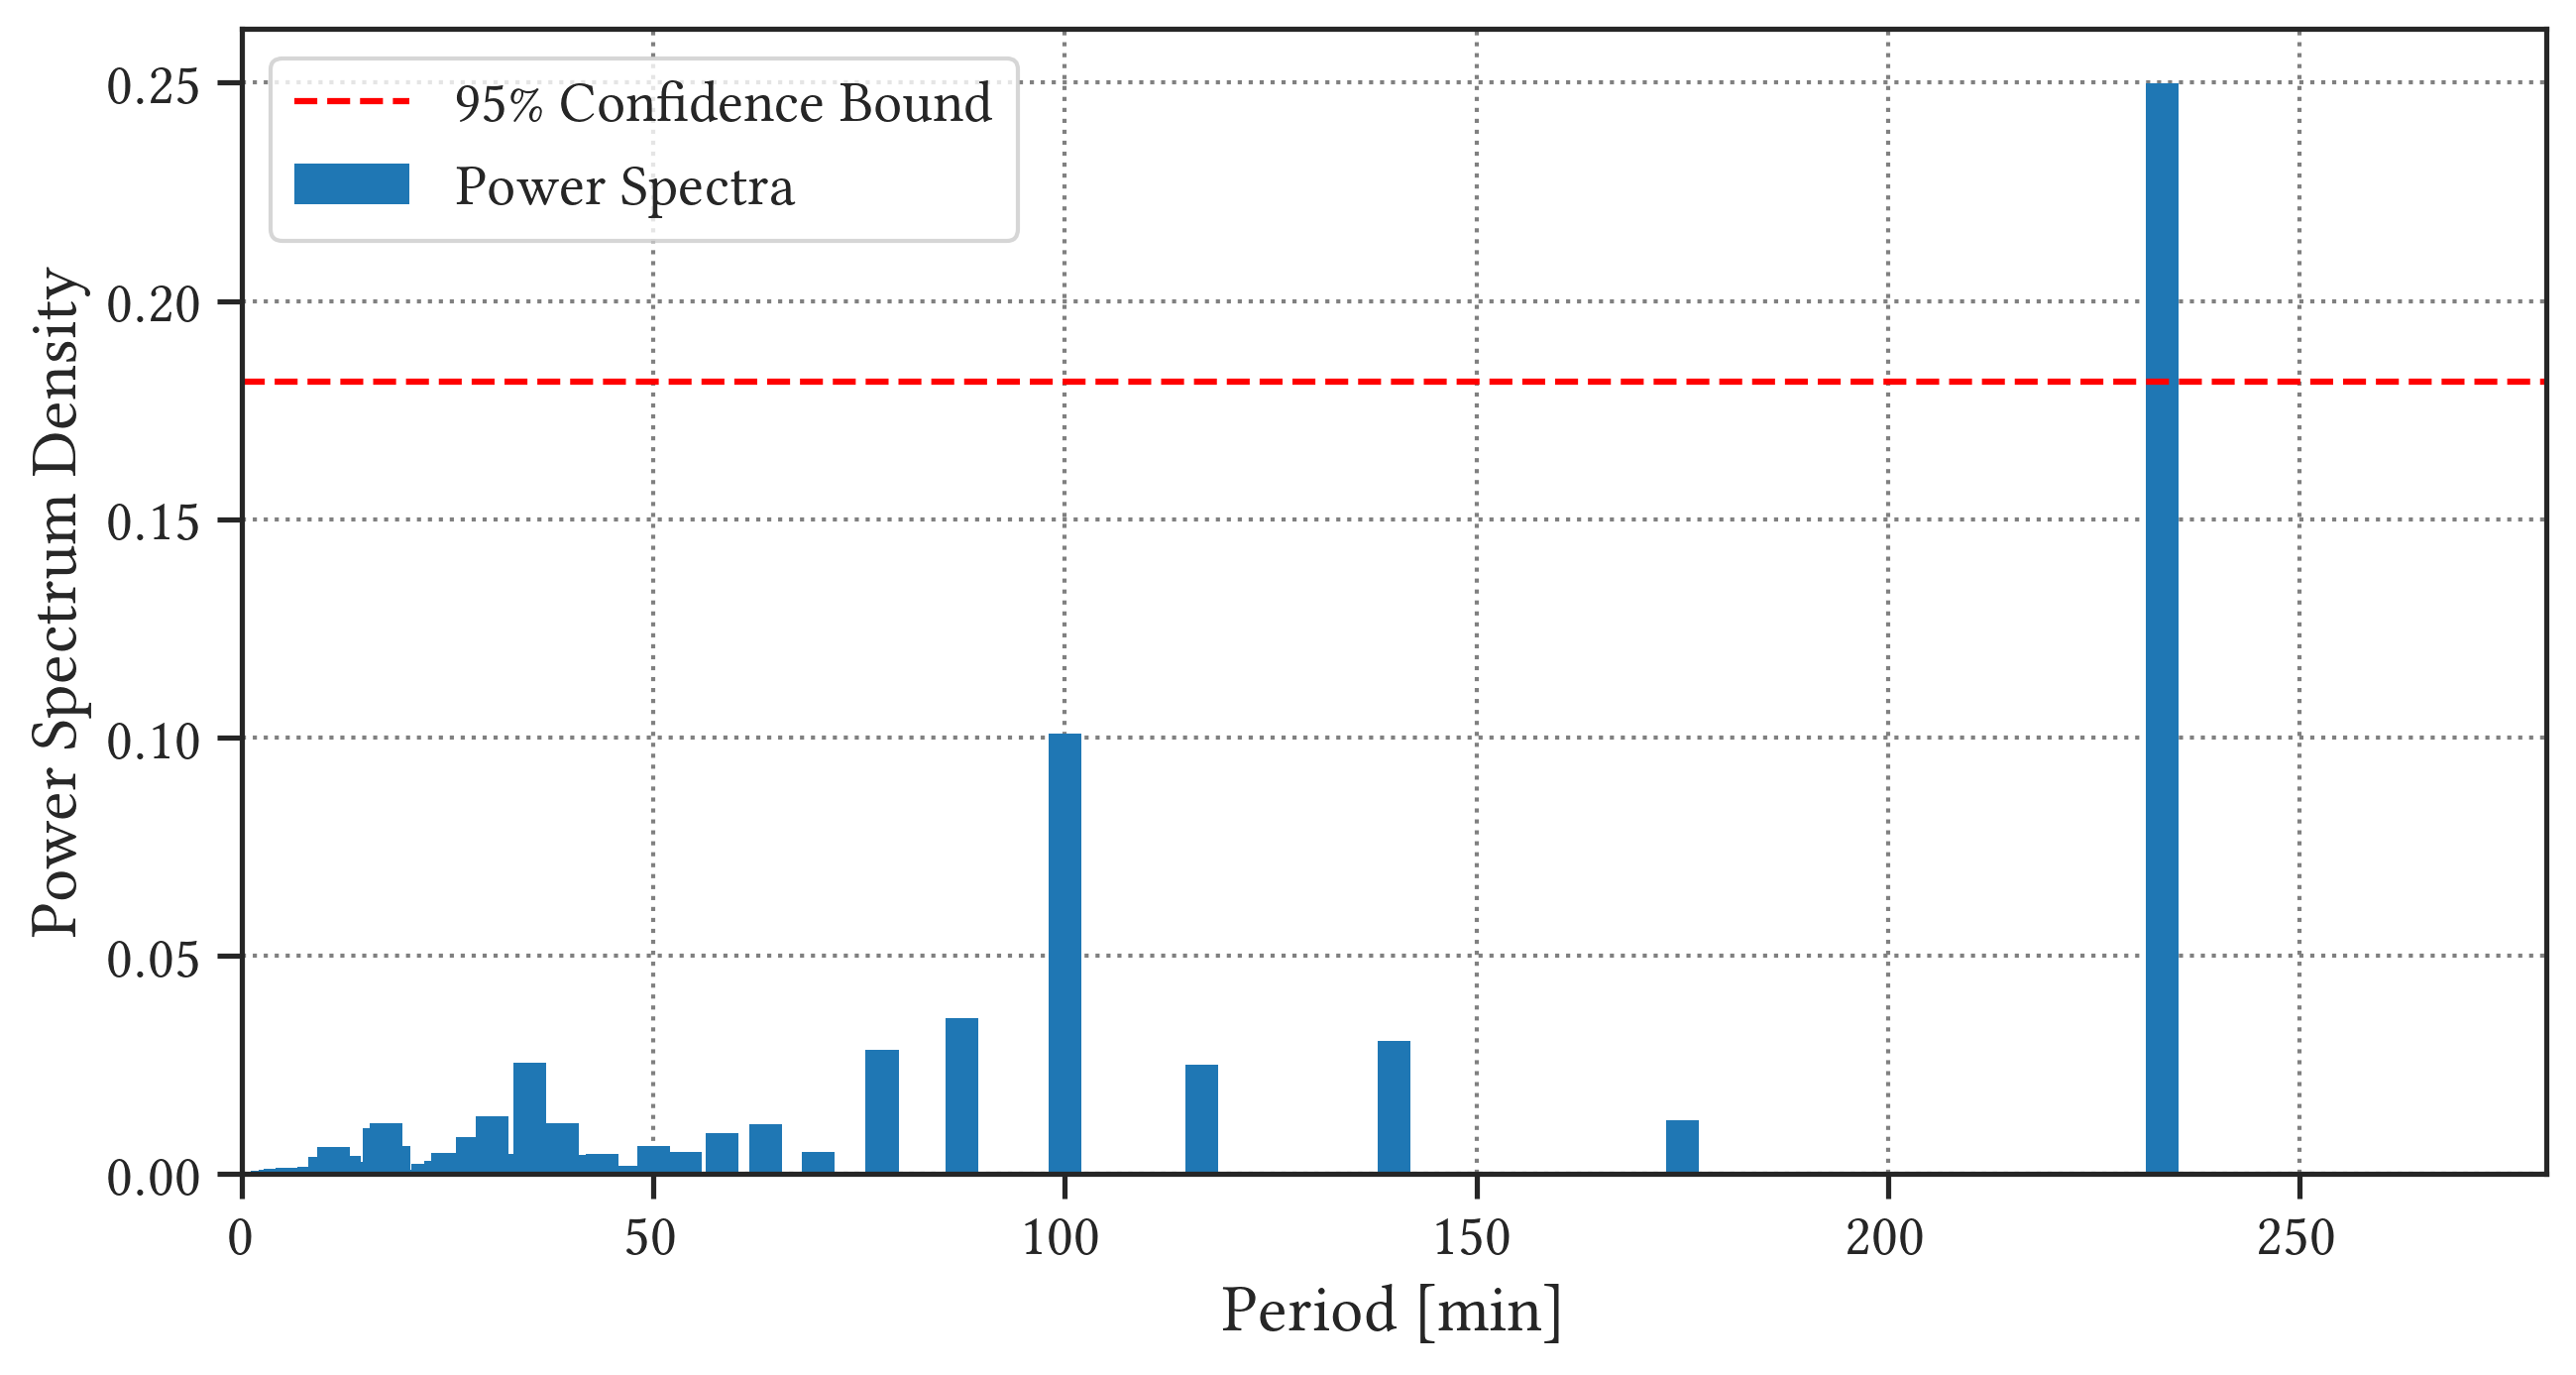

In [10]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (10, 5), dpi=300)

ax.bar(
    xx,
    yy,
    width=4,
    edgecolor="none",
    label="Power Spectra"
)

plt.axhline(
    y=var,
    color='r',
    linestyle='--',
    label="95\% Confidence Bound"
)

ax.legend(fontsize=14)

ax.set_xlim([0, 280])

ax.set_xlabel("Period [min]", fontsize=16)
ax.set_ylabel("Power Spectrum Density", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)